<a href="https://colab.research.google.com/github/FranBasili/RN2-TP1-Embeddings/blob/main/TP_Embeddings_b%C3%A1sico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Objetivo

El objetivo de las actividades propuestas es desarrollar intuición sobre la estructura semántica subyacente en embeddings de documentos y palabras básicos generados a partir de conteos y hacer un análisis exploratorio de forma cualitativa. Para ello se trabajará con el dataset 20 Newsgroups (disponible a través de sklearn) y diferentes formas de construir embeddings de documentos y de palabras:

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt


newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

# Funciones auxiliares

In [ ]:
sample_idx=101 #dejar igual al valor por defecto de printNeighbours

def printNeighbours(newsgroups, cos_dist, sample_idx=101):
  nearest_idx = np.array(cos_dist).flatten().argsort()[::-1]

  print("Sample idx:", sample_idx)
  print("Sample cat:", newsgroups.target_names[newsgroups.target[sample_idx]])
  print("\n Neighbours:")

  for idx in nearest_idx[1:10]:
      print("- idx:", idx,
            "\t cat:", newsgroups.target_names[newsgroups.target[idx]],
            "\t sim:", cos_dist[idx])

In [ ]:
def printNeighKeras(word_samples, neigh, cv, words_count):
  for word in word_samples:
    idx = cv.vocabulary_[word]
    _, neig = neigh.kneighbors(words_count[idx,:].reshape(1, -1))
    aux = cv.get_feature_names_out()
    print("Sample:", word)
    print(aux[neig[0]])

In [ ]:
def genWordWordMatrix(seqs, voc_size, win_size=5):

  # Generamos los skipgrams
  pairs, _= skipgrams(sequence=list(seqs), vocabulary_size=voc_size+1,
                            window_size=win_size, negative_samples=0,
                            sampling_table=make_sampling_table(voc_size+1,
                                                               sampling_factor=1),
                            shuffle=False)

  # Contamos los skipgrams
  pairs_u, counts = np.unique(pairs,return_counts=True, axis=0)

  # Armamos las tablas con los skipgrams
  word_word_matrix=lil_matrix((N, N))
  for _, (pair,count) in enumerate(zip(pairs_u, counts)):
    word_word_matrix[pair[0],pair[1]] += count

  return word_word_matrix

#Ejercicio 1

Usar las vectorizaciones disponibles en sklearn de CountVectorizer y TfidfVectorizer para construir la matriz de documento-término. Esto proveerá de embeddings para cada documento. Con esta vectorización explorar similaridad entre documentos (tomar algún documento y evaluar los documentos correspondientes con mayor similaridad), dado que el dataset provee también clasificación anotada en tópicos se aprovechar esta clasificación como elemento extra para comprobar la similaridad de documentos. Explorar vectorizar con diferentes cantidades de n-gramas. Toda exploración adicional a las mencionadas es bienvenida.

## EDA

In [ ]:
newsgroups.data[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

In [ ]:
print("Articulos totales:", len(newsgroups.data))

Articulos totales: 11314


In [ ]:
words_count=[len(newsgroups.data[article]) for article in range(len(newsgroups.data))]
print("Cant palabras totales:", np.sum(np.array(words_count)))

Cant palabras totales: 13781985


Text(0.5, 1.0, '20 News Group Trainset')

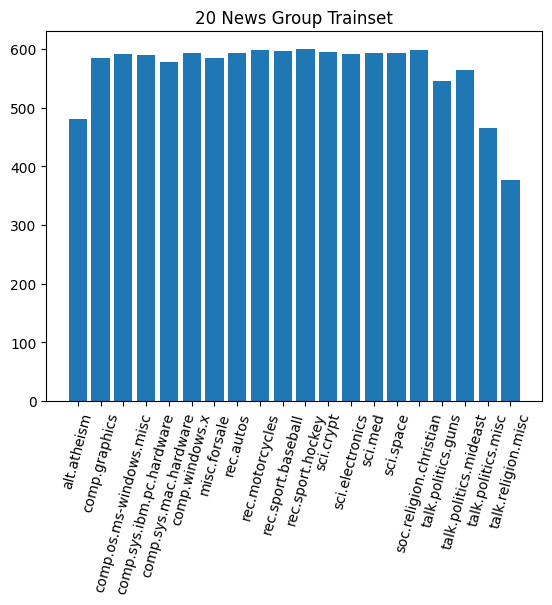

In [ ]:
count=[np.count_nonzero(newsgroups.target==value) for value in range(20)]
plt.bar(range(20), count)
plt.xticks(range(20), newsgroups.target_names, rotation=75)
plt.title('20 News Group Trainset')

In [ ]:
count_vectorizer = CountVectorizer(ngram_range=(1,1), max_df=1.0, min_df=100, stop_words="english")
TNG_cv = count_vectorizer.fit_transform(newsgroups.data)

print("Cant Palabras del diccionario:", len(count_vectorizer.get_feature_names_out()))
print("Palabras del diccionario")
count_vectorizer.get_feature_names_out()

Cant Palabras del diccionario: 1336
Palabras del diccionario


array(['00', '000', '10', ..., 'yes', 'york', 'young'], dtype=object)

In [ ]:
count_vectorizer.vocabulary_

{'wondering': 1312,
 'car': 207,
 'saw': 1049,
 'day': 331,
 'door': 387,
 'looked': 703,
 'late': 665,
 'early': 401,
 'called': 201,
 'really': 979,
 'small': 1106,
 'addition': 78,
 'separate': 1074,
 'rest': 1024,
 'body': 178,
 'know': 654,
 'model': 772,
 'engine': 419,
 'years': 1332,
 'history': 578,
 'info': 611,
 'looking': 704,
 'mail': 720,
 'fair': 459,
 'number': 823,
 'clock': 257,
 'send': 1071,
 'message': 754,
 'speed': 1130,
 'add': 76,
 'cards': 209,
 'floppy': 489,
 'disk': 376,
 '800': 55,
 'especially': 427,
 'days': 332,
 'network': 807,
 'knowledge': 656,
 'base': 152,
 'haven': 559,
 'thanks': 1204,
 'folks': 490,
 'mac': 716,
 'plus': 890,
 'finally': 483,
 'gave': 515,
 'starting': 1139,
 'life': 681,
 'way': 1290,
 'market': 734,
 'new': 808,
 'machine': 717,
 'bit': 170,
 'intended': 619,
 'maybe': 738,
 'bunch': 193,
 'questions': 960,
 'somebody': 1113,
 'answer': 104,
 'does': 383,
 'anybody': 107,
 'round': 1037,
 'expected': 448,
 'heard': 564,
 'supp

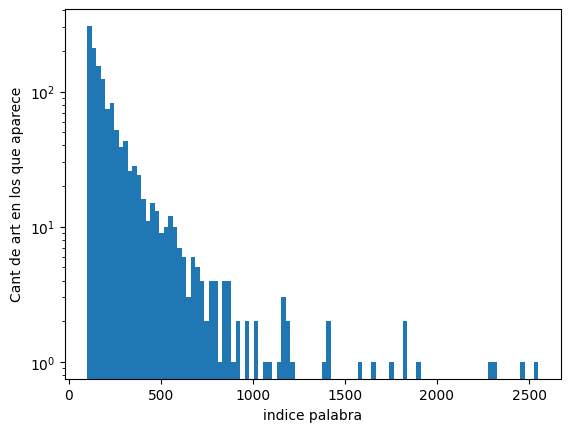

In [ ]:
doc_freq = np.array(TNG_cv.astype(bool).sum(axis=0)).flatten()
a = plt.hist(doc_freq, bins=100,log=True)
plt.xlabel("indice palabra")
plt.ylabel("Cant de art en los que aparece")
plt.show()

## Count Vectorizer 1-gramas

In [ ]:
# Transformar textos a matrices
count_vectorizer = CountVectorizer(ngram_range=(1,1), max_df=0.2, min_df=100, stop_words="english")
wordcount_cv1 = count_vectorizer.fit_transform(newsgroups.data)

In [ ]:
wordcount_norm = (wordcount_cv1.toarray().T/(np.linalg.norm(wordcount_cv1.toarray(), axis=-1)+1e-8)).T
cos_dist = np.dot(wordcount_norm[sample_idx], wordcount_norm.T)
printNeighbours(newsgroups, cos_dist)

Sample idx: 101
Sample cat: sci.electronics

 Neighbours:
- idx: 2356 	 cat: comp.os.ms-windows.misc 	 sim: 0.30323921624947586
- idx: 3414 	 cat: misc.forsale 	 sim: 0.29134281517931165
- idx: 6709 	 cat: comp.sys.mac.hardware 	 sim: 0.2785430053556214
- idx: 2088 	 cat: comp.sys.mac.hardware 	 sim: 0.2785430053556214
- idx: 1267 	 cat: comp.graphics 	 sim: 0.26681493741135137
- idx: 515 	 cat: comp.os.ms-windows.misc 	 sim: 0.26533431421829135
- idx: 539 	 cat: comp.windows.x 	 sim: 0.26261286337483186
- idx: 3037 	 cat: misc.forsale 	 sim: 0.259039734283655
- idx: 6571 	 cat: comp.sys.mac.hardware 	 sim: 0.25751310011989975


##Count Vectorizer 2-gramas

In [ ]:
# Transformar textos a matrices
count_vectorizer2 = CountVectorizer(ngram_range=(1,2), max_df=0.25, min_df=50, stop_words="english")
wordcount2 = count_vectorizer2.fit_transform(newsgroups.data)

In [ ]:
wordcount_norm = (wordcount2.toarray().T/(np.linalg.norm(wordcount2.toarray(), axis=-1)+1e-8)).T
cos_dist = np.dot(wordcount_norm[sample_idx], wordcount_norm.T)
printNeighbours(newsgroups, cos_dist)

Sample idx: 101
Sample cat: sci.electronics

 Neighbours:
- idx: 6571 	 cat: comp.sys.mac.hardware 	 sim: 0.28226724232129086
- idx: 4116 	 cat: sci.electronics 	 sim: 0.2705008884160407
- idx: 3558 	 cat: comp.graphics 	 sim: 0.2500781610493984
- idx: 2356 	 cat: comp.os.ms-windows.misc 	 sim: 0.2498780181317698
- idx: 6709 	 cat: comp.sys.mac.hardware 	 sim: 0.23426064129575225
- idx: 3414 	 cat: misc.forsale 	 sim: 0.22086305141432855
- idx: 1335 	 cat: comp.os.ms-windows.misc 	 sim: 0.22086305024302536
- idx: 515 	 cat: comp.os.ms-windows.misc 	 sim: 0.2143973613857909
- idx: 454 	 cat: sci.crypt 	 sim: 0.20300517600399762


##Count Vectorizer 3-gramas

In [ ]:
# Transformar textos a matrices
count_vectorizer3 = CountVectorizer(ngram_range=(1,3), max_df=0.25, min_df=50, stop_words="english")
wordcount3 = count_vectorizer3.fit_transform(newsgroups.data)

In [ ]:
wordcount3_norm = (wordcount3.toarray().T/(np.linalg.norm(wordcount3.toarray(), axis=-1)+1e-8)).T
cos_dist = np.dot(wordcount3_norm[sample_idx], wordcount3_norm.T)
printNeighbours(newsgroups, cos_dist)

Sample idx: 101
Sample cat: sci.electronics

 Neighbours:
- idx: 6571 	 cat: comp.sys.mac.hardware 	 sim: 0.28226724232129086
- idx: 4116 	 cat: sci.electronics 	 sim: 0.2705008884160407
- idx: 3558 	 cat: comp.graphics 	 sim: 0.2500781610493984
- idx: 2356 	 cat: comp.os.ms-windows.misc 	 sim: 0.2498780181317698
- idx: 6709 	 cat: comp.sys.mac.hardware 	 sim: 0.23426064129575225
- idx: 3414 	 cat: misc.forsale 	 sim: 0.22086305141432855
- idx: 1335 	 cat: comp.os.ms-windows.misc 	 sim: 0.22086305024302536
- idx: 515 	 cat: comp.os.ms-windows.misc 	 sim: 0.2143973613857909
- idx: 454 	 cat: sci.crypt 	 sim: 0.20300517600399762


## TFIDF 1-gramas

In [ ]:
# Transformar textos a matrices
Tfidf_vec = TfidfVectorizer(ngram_range=(1,1), max_df=0.25, min_df=50, stop_words="english")
wordcount_tfidf = Tfidf_vec.fit_transform(newsgroups.data)

In [ ]:
wordcount_norm = (wordcount_tfidf.toarray().T/(np.linalg.norm(wordcount_tfidf.toarray(), axis=-1)+1e-8)).T
cos_dist = np.dot(wordcount_norm[sample_idx], wordcount_norm.T)
printNeighbours(newsgroups, cos_dist)

Sample idx: 101
Sample cat: sci.electronics

 Neighbours:
- idx: 1335 	 cat: comp.os.ms-windows.misc 	 sim: 0.30565351223693193
- idx: 3558 	 cat: comp.graphics 	 sim: 0.2782806585695825
- idx: 4116 	 cat: sci.electronics 	 sim: 0.2735790141486182
- idx: 6571 	 cat: comp.sys.mac.hardware 	 sim: 0.269440932343452
- idx: 454 	 cat: sci.crypt 	 sim: 0.26894943271011185
- idx: 5306 	 cat: comp.graphics 	 sim: 0.2481168838378027
- idx: 6709 	 cat: comp.sys.mac.hardware 	 sim: 0.22063580583205183
- idx: 1353 	 cat: sci.crypt 	 sim: 0.21905179612338183
- idx: 11234 	 cat: comp.os.ms-windows.misc 	 sim: 0.21229259127950376


## TFIDF 2-gramas

In [ ]:
# Transformar textos a matrices
Tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_df=0.25, min_df=50, stop_words="english")
wordcount_tfidf2 = Tfidf_vec.fit_transform(newsgroups.data)

In [ ]:
wordcount_norm = (wordcount_tfidf2.toarray().T/(np.linalg.norm(wordcount_tfidf2.toarray(), axis=-1)+1e-8)).T
cos_dist = np.dot(wordcount_norm[sample_idx], wordcount_norm.T)
printNeighbours(newsgroups, cos_dist)

Sample idx: 101
Sample cat: sci.electronics

 Neighbours:
- idx: 1335 	 cat: comp.os.ms-windows.misc 	 sim: 0.30565351223693193
- idx: 3558 	 cat: comp.graphics 	 sim: 0.27542574679288157
- idx: 4116 	 cat: sci.electronics 	 sim: 0.2735790141486182
- idx: 6571 	 cat: comp.sys.mac.hardware 	 sim: 0.269440932343452
- idx: 454 	 cat: sci.crypt 	 sim: 0.26894943271011185
- idx: 5306 	 cat: comp.graphics 	 sim: 0.2481168838378027
- idx: 6709 	 cat: comp.sys.mac.hardware 	 sim: 0.22063580583205183
- idx: 1353 	 cat: sci.crypt 	 sim: 0.2173436089893961
- idx: 11234 	 cat: comp.os.ms-windows.misc 	 sim: 0.21229259127950376


## TFIDF 3-gramas

In [ ]:
# Transformar textos a matrices
Tfidf_vec = TfidfVectorizer(ngram_range=(1,3), max_df=0.25, min_df=50, stop_words="english")
wordcount_tfidf3 = Tfidf_vec.fit_transform(newsgroups.data)

In [ ]:
wordcount_norm = (wordcount_tfidf3.toarray().T/(np.linalg.norm(wordcount_tfidf3.toarray(), axis=-1)+1e-8)).T
cos_dist = np.dot(wordcount_norm[sample_idx], wordcount_norm.T)
printNeighbours(newsgroups, cos_dist)

Sample idx: 101
Sample cat: sci.electronics

 Neighbours:
- idx: 1335 	 cat: comp.os.ms-windows.misc 	 sim: 0.30565351223693193
- idx: 3558 	 cat: comp.graphics 	 sim: 0.27542574679288157
- idx: 4116 	 cat: sci.electronics 	 sim: 0.2735790141486182
- idx: 6571 	 cat: comp.sys.mac.hardware 	 sim: 0.269440932343452
- idx: 454 	 cat: sci.crypt 	 sim: 0.26894943271011185
- idx: 5306 	 cat: comp.graphics 	 sim: 0.2481168838378027
- idx: 6709 	 cat: comp.sys.mac.hardware 	 sim: 0.22063580583205183
- idx: 1353 	 cat: sci.crypt 	 sim: 0.2173436089893961
- idx: 11234 	 cat: comp.os.ms-windows.misc 	 sim: 0.21229259127950376


## Conclusiones



* El uso de TF-IDF o Count Vectorizer no brindó resultados sustancialmente distintivos.

* El uso de 2-gramas resultó beneficioso sobre 1-gramas, pero el uso de 3-gramas no dió mejoras frente a 2-gramas.

* Configurar correctamente el ```min_df``` y el ```max_df``` puede ser una de las maneras más directas de mejorar la representación de los textos y términos.


Cabe destacar que este analisis puede variar dependiendo de la categoria a analizar, ya que algunas se encuentran más "entrelazadas" que otras. Por ejemplo, Se inició el analisis con un artículo de la categoría "autos" pero estaba tan lejano al resto de categorías y clasificaba idealmente los textos similares que no se tomó como una métrica real.

# Ejercicio 2


Repetir la exploración de similaridad de documentos pero utilizando la vectorización resultante de aplicar truncated SVD (disponible en sklearn) a la matriz de documento-término.

##Count Vectorizer 2-gramas + SVD

In [ ]:
# Transformar textos a matrices
count_vectorizer2 = CountVectorizer(ngram_range=(1,2), max_df=0.25, min_df=50, stop_words="english")
count_cv = count_vectorizer2.fit_transform(newsgroups.data)

red = TruncatedSVD(n_components=250)
count_cv_red = red.fit_transform(count_cv)

In [ ]:
#Calculo de los vecinos
count_norm = (count_cv_red.T/(np.linalg.norm(count_cv_red, axis=-1)+1e-8)).T
cos_dist = np.dot(count_norm[sample_idx], count_norm.T)
printNeighbours(newsgroups, cos_dist)

Sample idx: 101
Sample cat: sci.electronics

 Neighbours:
- idx: 9669 	 cat: sci.space 	 sim: 0.4353920196391506
- idx: 8273 	 cat: rec.autos 	 sim: 0.4049529995975585
- idx: 8791 	 cat: sci.electronics 	 sim: 0.4022389617044571
- idx: 11078 	 cat: comp.windows.x 	 sim: 0.39629456718066997
- idx: 10857 	 cat: comp.os.ms-windows.misc 	 sim: 0.3933795951620791
- idx: 1621 	 cat: rec.motorcycles 	 sim: 0.3860750910395951
- idx: 6709 	 cat: comp.sys.mac.hardware 	 sim: 0.38336448030774073
- idx: 3362 	 cat: misc.forsale 	 sim: 0.3811251507403148
- idx: 5076 	 cat: comp.sys.mac.hardware 	 sim: 0.3790246320832596


##TFIDF 2-gramas + SVD

In [ ]:
# Transformar textos a matrices
Tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_df=0.25, min_df=50, stop_words="english")
count_tfidf = Tfidf_vec.fit_transform(newsgroups.data)

red = TruncatedSVD(n_components=250)
count_tfidf_red = red.fit_transform(count_tfidf)

In [ ]:
#Calculo de los vecinos
count_norm = (count_tfidf_red.T/(np.linalg.norm(count_tfidf_red, axis=-1)+1e-8)).T
cos_dist = np.dot(count_norm[sample_idx], count_norm.T)
printNeighbours(newsgroups, cos_dist)

Sample idx: 101
Sample cat: sci.electronics

 Neighbours:
- idx: 6571 	 cat: comp.sys.mac.hardware 	 sim: 0.4944860809613492
- idx: 9744 	 cat: comp.os.ms-windows.misc 	 sim: 0.4855841960086731
- idx: 2356 	 cat: comp.os.ms-windows.misc 	 sim: 0.4696874825823462
- idx: 8988 	 cat: comp.sys.ibm.pc.hardware 	 sim: 0.4668637705037127
- idx: 3414 	 cat: misc.forsale 	 sim: 0.4416753529372383
- idx: 6709 	 cat: comp.sys.mac.hardware 	 sim: 0.42683896678801797
- idx: 7698 	 cat: soc.religion.christian 	 sim: 0.4154278324537882
- idx: 2088 	 cat: comp.sys.mac.hardware 	 sim: 0.41085540517660846
- idx: 3459 	 cat: comp.windows.x 	 sim: 0.40451660930729216


## Conclusiones

Si bien la reducción de la dimensionalidad redujo el costo computacional, empeoró la performance de las estimaciones. Ahora casi ninguno de los textos calificados como similares es de la misma categoría que el tomado como sample aunque es cierto que en su mayoría presentan categorías relacionadas.



# Ejercicio 3


Transponer la matriz documento-término, esto resultará en la matriz término-documento que provee embeddings de palabras. Explorar similaridad entre términos.

In [ ]:
# Transformar textos a matrices
cv = CountVectorizer(ngram_range=(1,2), max_df=0.25, min_df=50, stop_words="english")
count_cv = cv.fit_transform(newsgroups.data)

red = TruncatedSVD(n_components=100)
count_cv_red = red.fit_transform(count_cv.T)

## Display de palabras similares

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
word_samples=["new york", "science", "church", "women", "nasa"]

neigh = NearestNeighbors(n_neighbors=20, metric="cosine").fit(count_cv_red)

printNeighKeras(word_samples=word_samples, neigh=neigh, cv=cv,
                words_count=count_cv_red)

Sample: new york
['new york' 'york' 'north' 'boston' 'minnesota' 'montreal' 'new'
 'washington' 'chicago' 'pittsburgh' 'detroit' 'toronto' 'league'
 'rangers' 'seat' 'teams' 'sports' 'hockey' 'nhl' 'bay']
Sample: science
['science' 'scientific' 'general' 'elements' 'matter' 'material' 'star'
 'lack' 'charge' 'absolute' 'engineering' 'related' 'books' 'nasa'
 'society' 'existence' 'evidence' 'flight' 'theory' 'universe']
Sample: church
['church' 'catholic' 'doctrine' 'traditional' 'spiritual' 'divine'
 'teaching' 'faith' 'christian' 'claiming' 'gay' 'tradition' 'christians'
 'followers' 'christianity' 'sexual' 'interpret' 'sex' 'scripture' 'roman']
Sample: women
['women' 'alive' 'brought' 'lay' 'head' 'hospital' 'soldiers' 'burned'
 'woman' 'killing' 'lived' 'came' 'started' 'happened' 'town' 'thrown'
 'eyes' 'heard' 'couldn' 'leave']
Sample: nasa
['nasa' 'nasa gov' 'shuttle' 'flight' 'gov' 'space' 'reports'
 'available anonymous' 'elements' 'johnson' 'science' '140' 'facility'
 'cost' 

## Representacion con TSNE

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

X_embedded = TSNE(n_components=2,metric="cosine").fit_transform(count_cv_red)

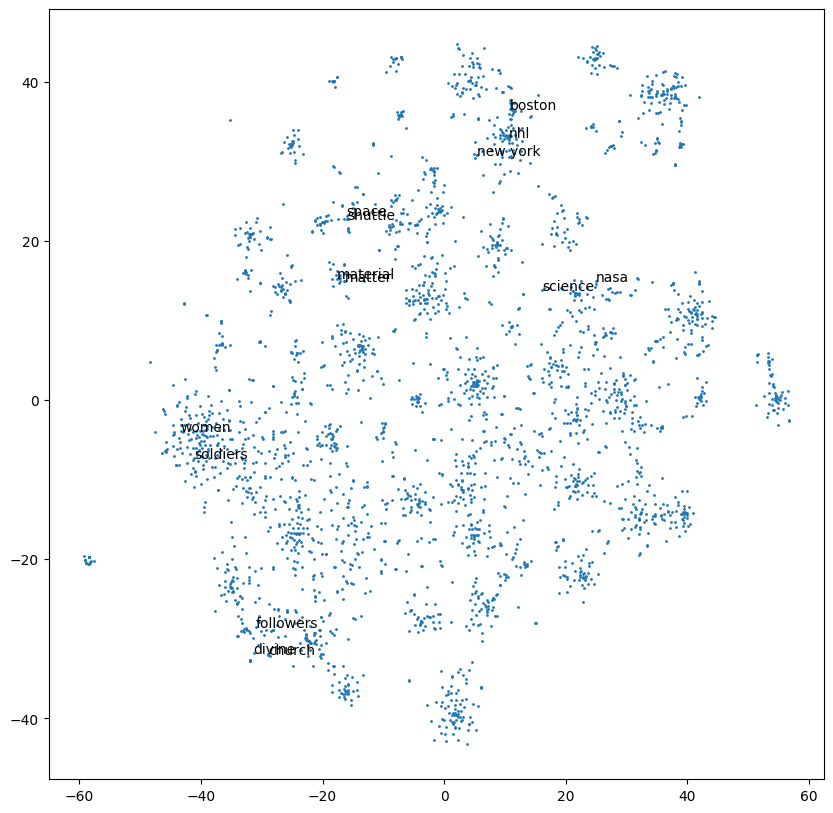

In [ ]:
words=['new york', 'boston', 'nhl',         # Palabras simil new york
       'science', 'matter', 'material',     # Palabras simil science
       'church', 'divine', 'followers',     # Palabras simil church
       'women', 'soldiers',                 # Palabras simil women
       'nasa', 'shuttle', 'space'     # Palabras simil nasa
       ]

plt.figure(figsize=[10,10])
plt.scatter(X_embedded[:,0],X_embedded[:,1], s=1)

for word in words:
    idx = cv.vocabulary_[word]
    plt.text(X_embedded[idx,0],X_embedded[idx,1],word)

## Conclusiones

Podemos ver que, en su mayoría, los terminos que el embedding propone como similares a los samples son realmente similares. Realizando la descomposicion con TSNE podemos ver gráficamente que estos términos similares se encuentran ubicados cerca de los samples.

# Ejercicio 4



Construir la matriz término-clase con las clases disponibles en 20 Newsgroups y con estos embeddings de palabras resultantes explorar similaridad entre términos.

In [ ]:
count_vectorizer = CountVectorizer(ngram_range=(1,2), max_df=0.25, min_df=100, stop_words="english")
TNG_count = count_vectorizer.fit_transform(newsgroups.data)

# Obtener los términos (palabras) en orden
terms = count_vectorizer.get_feature_names_out()

## Generación Matriz Término-Clase



In [ ]:
# Primero indexas la categoría despues el termino
term_counts=np.zeros((len(terms), len(newsgroups.target_names)))

# Contar la cantidad de veces que aparece cada término en cada clase
for category_id, category_name in enumerate(newsgroups.target_names):
    term_counts[:,category_id] = TNG_count[newsgroups.target == category_id].sum(axis=0).tolist()[0]

In [ ]:
term_counts

array([[  0.,  26.,  18., ...,   7.,  15.,   1.],
       [ 17.,  12.,   3., ..., 145.,  53.,   9.],
       [  5.,  54.,  39., ...,  59.,  58.,  22.],
       ...,
       [ 49.,  29.,  25., ...,  62.,  95.,  35.],
       [  4.,   9.,   0., ...,  51.,  32.,   4.],
       [ 16.,   1.,   2., ...,  64.,  63.,  13.]])

## Exploración similitud

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
word_samples=["new york", "science", "church", "women", "nasa"]

neigh = NearestNeighbors(n_neighbors=20, metric="cosine").fit(term_counts)
printNeighKeras(word_samples=word_samples, neigh=neigh, cv=count_vectorizer,
                words_count=term_counts)

Sample: new york
['new york' 'york' 'san' 'night' 'young' 'west' 'guy' 'gone' 'year' 'city'
 'looked' 'home' 'guys' 'wasn' 'east' 'close' 'chance' 'lose' 'years'
 'past']
Sample: science
['science' 'theory' 'scientific' 'significant' 'research' 'dr' 'caused'
 'studies' 'eventually' 'age' 'results' 'references' 'taking' 'natural'
 'practice' 'effects' 'causes' 'alternative' 'highly' 'weight']
Sample: church
['church' 'christ' 'lord' 'faith' 'christians' 'christianity' 'truth'
 'god' 'hell' 'paul' 'jesus' 'christian' 'love' 'authority' 'beliefs'
 'bible' 'father' 'acts' 'understanding' 'son']
Sample: women
['women' 'brought' 'killing' 'said' 'peace' 'told' 'lived' 'woman'
 'history' 'happened' 'couldn' 'population' 'forces' 'anti' 'wife'
 'jewish' 'turned' 'saw' 'started' 'came']
Sample: nasa
['nasa' 'space' 'station' 'dc' 'earth' 'vehicle' 'surface' 'project'
 'development' 'commercial' 'mass' 'engineering' 'cost' 'institute'
 'material' 'design' 'center' 'gov' 'costs' 'sci']


## Terminos frecuentes por clase

In [ ]:
term_frec=np.zeros((len(terms), len(newsgroups.target_names)))

for word in range(len(terms)):
  term_frec[word,:] = term_counts[word,:] / term_counts[word,:].sum(axis=0).tolist()

for category_id, category_name in enumerate(newsgroups.target_names):
  freq_terms = np.argsort(term_frec[:,category_id])[::-1]
  print("\n Category:", category_name)
  print(terms[freq_terms[:5]])


 Category: alt.atheism
['belief' 'religious' 'religion' 'argument' 'conclusion']

 Category: comp.graphics
['image' 'graphics' 'images' 'format' 'convert']

 Category: comp.os.ms-windows.misc
['windows' '34' '45' 'air' 'ms']

 Category: comp.sys.ibm.pc.hardware
['ide' 'controller' 'scsi' 'drives' 'bus']

 Category: comp.sys.mac.hardware
['apple' 'mac' 'internal' 'external' 'ram']

 Category: comp.windows.x
['motif' 'window' 'mit' 'server' 'output']

 Category: misc.forsale
['sale' 'shipping' 'offer' '00' 'condition']

 Category: rec.autos
['cars' 'car' 'dealer' 'engine' 'driving']

 Category: rec.motorcycles
['bike' 'miles' 'piece' 'road' 'hey']

 Category: rec.sport.baseball
['baseball' 'fan' 'hit' 'runs' 'players']

 Category: rec.sport.hockey
['nhl' 'hockey' 'season' 'la' 'teams']

 Category: sci.crypt
['encryption' 'nsa' 'clipper' 'secure' 'keys']

 Category: sci.electronics
['ground' 'hot' 'supply' 'pin' 'signal']

 Category: sci.med
['gordon' 'doctor' 'medical' 'treatment' 'bank

## Conclusiones
Analizando qué términos son más frecuentes en cada clase podemos obtener una muy buena caracterización o representación de dicha clase.

Una observación considerable es que hay palabras como "women" que resultan mucho más complicado de buscar términos relacionados que otras como "nasa". Esto muy posiblemente se deba a que dicha palabra no esta en una categoria especifica, sino que se encuentre en varias categorias y por ello no presentan términos asociados particulares.

# Ejercicio 5

Construir la matriz término-término utilizando una ventana de contexto. Para construir esta matriz serán útiles las funcionalidades de Keras make_sampling_table, skipgrams y el tokenizador de Keras. Explorar resultados de similaridad de términos con diferentes tamaños de contexto.

## Tokenización de textos

In [ ]:
from keras.preprocessing.text import Tokenizer
N=10000
tokenizer = Tokenizer(num_words=N)    # Instanciamos el tokenizador
tokenizer.fit_on_texts(newsgroups.data) # Ajustamos el tokenizador

# Pasamos cada texto a sus respectivos tokens
seqs=tokenizer.texts_to_sequences(newsgroups.data)
all_seqs=np.hstack(seqs).astype(int)

In [ ]:
all_seqs

array([   7,   26, 1383, ...,  181,   41, 4767])

## Skipgrams


In [ ]:
from keras.preprocessing.sequence import make_sampling_table, skipgrams
from scipy.sparse import lil_matrix
from sklearn.neighbors import NearestNeighbors

def genWordWordMatrix(seqs, voc_size=N, win_size=5):

  # Generamos los skipgrams
  pairs, _= skipgrams(sequence=list(seqs), vocabulary_size=voc_size+1,
                            window_size=win_size, negative_samples=0,
                            sampling_table=make_sampling_table(voc_size+1,
                                                               sampling_factor=1),
                            shuffle=False)

  # Contamos los skipgrams
  pairs_u, counts = np.unique(pairs,return_counts=True, axis=0)

  # Armamos las tablas con los skipgrams
  word_word_matrix=lil_matrix((N, N))
  for _, (pair,count) in enumerate(zip(pairs_u, counts)):
    word_word_matrix[pair[0],pair[1]] += count

  return word_word_matrix

## Exploracion similitud

In [ ]:
samples=["york"]
sizes=[1,3,5,10]

for size in sizes:
  word_word_matrix=genWordWordMatrix(all_seqs, voc_size=N, win_size=size)

  red = TruncatedSVD(n_components=100)
  TNG_cv_red = red.fit_transform(word_word_matrix.T)

  neigh = NearestNeighbors(n_neighbors=20, metric="cosine").fit(TNG_cv_red)

  for word in samples:
    idx_1 = tokenizer.word_index[word]
    _, neig = neigh.kneighbors(TNG_cv_red[idx_1:idx_1+1])
    print("Sample:", word, "- Skipgrams Size:", size)
    print([tokenizer.index_word[n] for n in neig[0]])

Sample: york - Skipgrams Size: 1
['york', 'jersey', 'zealand', 'haven', 'testament', 'brand', 'mexico', 'hobgoblin', 'england', 'luck', 'abiding', 'nw', 'sweet', 'enforcement', 'intro', 'avenue', 'vg', 'publishers', 'ni', 'telecommunications']
Sample: york - Skipgrams Size: 3
['york', 'zealand', 'england', 'london', 'testament', 'usa', 'mexico', '1992', 'san', 'cities', 'washington', 'francisco', '1982', '1989', 'city', 'western', 'english', 'florida', 'versus', 'december']
Sample: york - Skipgrams Size: 5
['york', 'zealand', 'washington', 'florida', '1989', 'san', 'london', 'england', 'francisco', '1982', 'mexico', '1992', '1988', 'december', '1987', '1991', 'canada', '1986', 'texas', 'usa']
Sample: york - Skipgrams Size: 10
['york', 'washington', 'florida', 'san', 'francisco', '1987', '1989', 'zealand', 'texas', 'california', 'england', '1992', '1988', 'canada', 'bay', '1990', 'seattle', '1991', '1982', 'division']


## Conclusiones

A medida que se aumenta el tamaño de la ventana el costo computacional crece rápidamente pero se generan mejores resultados en la similitud entre palabras. Por ejemplo, con un tamaño de ventana 1 vemos como las palabras cercanas a "york" son variadas, con tamaño de ventana 3 ya son en su mayoría países y con tamaño de ventana 10 son ciudades de Estados Unidos o años de importancia para la ciudad.

# Ejercicio 6


Con la matriz término-término construir la matriz de PPMI y factorizarla aplicando truncated SVD. Explorar resultados de similaridad término a término.


In [ ]:
from keras.preprocessing.sequence import make_sampling_table, skipgrams
from keras.preprocessing.text import Tokenizer
from sklearn.neighbors import NearestNeighbors

In [ ]:
N=10000
tokenizer = Tokenizer(num_words=N)    # Instanciamos el tokenizador
tokenizer.fit_on_texts(newsgroups.data) # Ajustamos el tokenizador

# Pasamos cada texto a sus respectivos tokens
seqs=tokenizer.texts_to_sequences(newsgroups.data)
all_seqs=np.hstack(seqs).astype(int)

word_word_matrix=genWordWordMatrix(all_seqs, voc_size=N, win_size=5)

## Calculo matriz PPMI

In [ ]:
p_x = word_word_matrix[1:,1:].sum(axis=1)/word_word_matrix[1:,1:].sum()
p_xy = word_word_matrix[1:,1:]/word_word_matrix[1:,1:].sum()

cociente =np.array(p_xy/np.dot(p_x, p_x.T))
PMI = np.log(cociente*(cociente>1)+1e-8)
PPMI=PMI*(PMI>0)+1e-8

In [ ]:
PPMI

array([[5.94395233e-02, 1.00000000e-08, 1.33769465e-01, ...,
        1.00000000e-08, 1.00000000e-08, 1.00000000e-08],
       [1.00000000e-08, 3.33971962e+00, 1.00000000e-08, ...,
        6.71137658e-01, 4.19823231e-01, 2.65672552e-01],
       [1.37008253e-01, 1.00000000e-08, 1.00000000e-08, ...,
        1.00000000e-08, 1.00000000e-08, 1.00000000e-08],
       ...,
       [1.00000000e-08, 6.71137658e-01, 1.00000000e-08, ...,
        1.00000000e-08, 1.00000000e-08, 1.00000000e-08],
       [1.00000000e-08, 4.19823231e-01, 1.00000000e-08, ...,
        1.00000000e-08, 1.00000000e-08, 1.00000000e-08],
       [1.00000000e-08, 2.65672552e-01, 1.00000000e-08, ...,
        1.00000000e-08, 1.00000000e-08, 1.00000000e-08]])

## Exploracion similitud

In [ ]:
word_samples=["york", "science", "church", "women", "nasa"]

PPMI_red = TruncatedSVD(n_components=300).fit_transform(PPMI)

neigh = NearestNeighbors(n_neighbors=20, metric="cosine").fit(PPMI_red)

for word in word_samples:
  idx = tokenizer.word_index[word]-1
  _, neig = neigh.kneighbors(PPMI_red[idx:idx+1])
  print("Sample:", word)
  print([tokenizer.index_word[n+1] for n in neig[0]])

Sample: york
['york', 'washington', 'new', 'ny', 'boston', 'avenue', 'city', 'chicago', 'milwaukee', 'philadelphia', 'pennsylvania', '212', 'pittsburgh', 'rangers', 'minnesota', 'press', 'baltimore', 'street', 'montreal', 'oakland']
Sample: science
['science', 'scientific', 'research', 'computer', 'institute', 'philosophy', 'theory', 'project', 'sciences', 'space', 'university', 'technology', 'of', 'observations', 'psychology', 'national', 'understanding', 'empirical', 'studies', 'study']
Sample: church
['church', 'catholic', 'orthodox', 'christian', 'churches', 'doctrine', 'lutheran', 'coptic', 'pope', 'theology', 'catholics', 'worship', 'bishops', 'faith', 'christ', 'heresy', 'priest', 'rome', 'bishop', 'schism']
Sample: women
['women', 'children', 'men', 'were', 'people', 'burned', 'woman', 'elderly', 'raped', 'massacred', 'who', 'pregnant', 'killed', 'innocent', 'they', 'young', 'soldiers', 'girls', 'babies', 'her']
Sample: nasa
['nasa', 'jpl', 'gov', 'ames', 'jsc', 'space', 'larc'

## Conclusiones
Las palabras asociadas a cada samples efectivamente se corresponden.
